In [3]:
%pip install newsapi-python
%pip install --upgrade transformers
%pip install bert-for-sequence-classification
from newsapi import NewsApiClient
import json
import torch
from wordcloud import WordCloud
import pandas as pd
import os
print(torch.__version__)


[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: C:\Users\franc\OneDrive\Documents\Admin\Universiteit\Akademies\Year 3\Data Science 346\Project\DS346proj\myenv\Scripts\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: C:\Users\franc\OneDrive\Documents\Admin\Universiteit\Akademies\Year 3\Data Science 346\Project\DS346proj\myenv\Scripts\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
2.4.1+cpu



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: C:\Users\franc\OneDrive\Documents\Admin\Universiteit\Akademies\Year 3\Data Science 346\Project\DS346proj\myenv\Scripts\python.exe -m pip install --upgrade pip


In [1]:
import json

# Function to read JSON file
def read_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

# Function to write JSON file
def write_json(file_path, data):
    with open(file_path, 'w') as file:
        json.dump(data, file, indent=4)

# Load Harris and Trump articles
harris_articles_path = 'dataset/cleaned_harris_articles.json'
trump_articles_path = 'dataset/cleaned_trump_articles.json'

harris_articles = read_json(harris_articles_path)
trump_articles = read_json(trump_articles_path)

# Extract first 40 articles for testing
harris_test_articles = harris_articles[:40]
trump_test_articles = trump_articles[:40]

# Save the first 40 Harris articles to harris_test.json
harris_test_path = 'dataset/test_harris.json'
write_json(harris_test_path, harris_test_articles)

# Save the first 40 Trump articles to trump_test.json
trump_test_path = 'dataset/test_trump.json'
write_json(trump_test_path, trump_test_articles)

# Remove the first 40 articles from the original datasets
harris_train_articles = harris_articles[40:]
trump_train_articles = trump_articles[40:]

# Save the remaining Harris articles to train_harris.json
harris_train_path = 'dataset/train_harris.json'
write_json(harris_train_path, harris_train_articles)

# Save the remaining Trump articles to train_trump.json
trump_train_path = 'dataset/train_trump.json'
write_json(trump_train_path, trump_train_articles)

print(f"Saved first 40 Harris articles to {harris_test_path} and remaining articles to {harris_train_path}.")
print(f"Saved first 40 Trump articles to {trump_test_path} and remaining articles to {trump_train_path}.")

Saved first 40 Harris articles to dataset/test_harris.json and remaining articles to dataset/train_harris.json.
Saved first 40 Trump articles to dataset/test_trump.json and remaining articles to dataset/train_trump.json.


In [2]:
import os
import json
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Ensure necessary NLTK resources are downloaded
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
sid = SentimentIntensityAnalyzer()



# Function to load articles from local files
def get_articles():
    # Load Harris articles from local file
    with open('dataset/train_harris.json', 'r') as harris_file:
        harris_articles = json.load(harris_file)

    # Load Trump articles from local file
    with open('dataset/train_trump.json', 'r') as trump_file:
        trump_articles = json.load(trump_file)
    
    # Assuming the structure is already a list of articles in both JSON files
    return harris_articles, trump_articles

# Call the function to get articles
harris_articles, trump_articles = get_articles()

def get_test_articles():
    # Load Harris articles from local file
    with open('dataset/test_harris.json', 'r') as harris_file:
        harris_articles = json.load(harris_file)

    # Load Trump articles from local file
    with open('dataset/test_trump.json', 'r') as trump_file:
        trump_articles = json.load(trump_file)
    
    # Assuming the structure is already a list of articles in both JSON files
    return harris_articles, trump_articles

# Call the function to get articles
harris_test_articles, trump_test_articles = get_test_articles()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jaco/nltk_data...
[nltk_data] Downloading package punkt to /home/jaco/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/jaco/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/jaco/nltk_data...
[nltk_data] Downloading package omw-1.4 to /home/jaco/nltk_data...


In [6]:
import re
import pandas as pd
from nltk.tokenize import sent_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download("punkt_tab")

sid = SentimentIntensityAnalyzer()

def preprocess(text):
    # Convert to lowercase
    text = text.lower()
    
    patterns = [r'\bkamala\b', r'\bharris\b', r'\bdonald\b', r'\btrump\b', r'\btrumps\b']
    for pattern in patterns:
        text = re.sub(pattern, '', text)
    
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word.isalpha()]
    
    words = [word for word in words if word not in stop_words]
    
    return ' '.join(words)

def calculate_sentiment_for_article(article):
    """
    Calculate the total sentiment score for an article.
    """
    sentences = sent_tokenize(article)
    total_score = 0
    
    # Calculate sentiment for each sentence and sum the scores
    for sentence in sentences:
        
        sentiment = sid.polarity_scores(sentence)
        total_score += sentiment['compound']
    
    return total_score

def process_articles(articles, publication_dates, candidate_name):
    candidate_data = []
    
    for article, published_at in zip(articles, publication_dates):
        title = article.get('title', '')
        description = article.get('description', '')

        if title and description:  # If title is not empty, process it
            cleaned_title = preprocess(title)
            cleaned_description = preprocess(description)
            title_score = calculate_sentiment_for_article(cleaned_title)
            candidate_data.append({
                'article': cleaned_title + " " + cleaned_description,
                'candidate': candidate_name,
                'score': title_score,
                'publishedAt': published_at
            })
    
    return candidate_data

# harris_articles = pd.read_json('./dataset/cleaned_harris_articles.json')
# trump_articles = pd.read_json('./dataset/cleaned_trump_articles.json')

harris_publication_dates = [article['publishedAt'] for article in harris_articles]
trump_publication_dates = [article['publishedAt'] for article in trump_articles]

# Process articles for both candidates
harris_data = process_articles(harris_articles, harris_publication_dates, "Kamala Harris")
trump_data = process_articles(trump_articles, trump_publication_dates, "Donald Trump")


df_trump_train = pd.DataFrame(trump_data)
df_harris_train = pd.DataFrame(harris_data)

df_harris_train.to_csv('dataset/train_harris.csv', index=False)
df_trump_train.to_csv('dataset/train_trump.csv', index=False)

# Combine both datasets
articles_data = harris_data + trump_data

# Convert to a DataFrame for further analysis
df_articles = pd.DataFrame(articles_data)

# print(df_articles)

df_articles.to_csv('dataset/train_combined.csv', index=False)

[nltk_data] Downloading package punkt_tab to /home/jaco/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [7]:
from collections import Counter

def get_top_words_and_words_above_10(candidate_data):
    all_words = []
    for item in candidate_data:
        words = item['article'].split()
        all_words.extend(words)
    
    word_counts = Counter(all_words)
    
    # Get the top 10 most common words
    top_10_words = [word for word, _ in word_counts.most_common(10)]
    
    # Get words with counts higher than 10
    words_above_10 = [word for word, count in word_counts.items() if count > 10]
    
    return top_10_words, words_above_10

# Get both the top 10 words and words with counts higher than 10 for Harris and Trump articles
harris_top_10, harris_words_above_10 = get_top_words_and_words_above_10(harris_data)
trump_top_10, trump_words_above_10 = get_top_words_and_words_above_10(trump_data)

print("Top 10 words in Harris articles:", harris_top_10)
print("Words in Harris articles with counts > 10:", harris_words_above_10)

print("Top 10 words in Trump articles:", trump_top_10)
print("Words in Trump articles with counts > 10:", trump_words_above_10)


Top 10 words in Harris articles: ['president', 'vice', 'news', 'post', 'ha', 'campaign', 'former', 'poll', 'voter', 'republican']
Words in Harris articles with counts > 10: ['tim', 'walz', 'lie', 'want', 'abortion', 'news', 'also', 'today', 'post', 'debate', 'tuesday', 'take', 'actually', 'vp', 'cnn', 'rally', 'attack', 'told', 'vice', 'president', 'wa', 'made', 'first', 'campaign', 'million', 'appeared', 'voter', 'think', 'economy', 'rant', 'man', 'republican', 'pennsylvania', 'democratic', 'vote', 'speech', 'right', 'georgia', 'support', 'policy', 'liz', 'cheney', 'ha', 'endorsed', 'say', 'gop', 'endorsement', 'country', 'video', 'abc', 'host', 'among', 'joe', 'better', 'democrat', 'former', 'try', 'claimed', 'assassination', 'political', 'asked', 'claim', 'one', 'people', 'administration', 'fox', 'called', 'time', 'new', 'harris', 'look', 'voting', 'white', 'could', 'win', 'show', 'american', 'since', 'health', 'biden', 'medium', 'record', 'day', 'poll', 'two', 'point', 'house', 'wo

In [9]:
def process_test_articles(articles, candidate_name):
    candidate_data = []
    
    for article in articles:
        title = article.get('title', '')
        description = article.get('description', '')
        score = article.get('score', 0)  # Use the score directly from the test data
        
        if title and description:
            cleaned_title = preprocess(title)
            cleaned_description = preprocess(description)
            candidate_data.append({
                'article': cleaned_title + ' ' + cleaned_description,
                'score': score
            })
        
    
    return candidate_data

#harris_test_articles = read_json('./dataset/harris_test.json')
#trump_test_articles = read_json('./dataset/trump_test.json')

harris_test_data = process_test_articles(harris_test_articles, "Kamala Harris")
trump_test_data = process_test_articles(trump_test_articles, "Donald Trump")
                
df_test_harris = pd.DataFrame(harris_test_data)
df_test_harris.to_csv('dataset/test_harris.csv', index=False)
df_test_trump = pd.DataFrame(trump_test_data)
df_test_trump.to_csv('dataset/test_trump.csv', index=False)


test_articles_data = harris_test_data + trump_test_data
df_test_articles = pd.DataFrame(test_articles_data)
                
print(df_test_articles)

                                              article  score
0   accepts cnn invitation tv debate ha yet commen...      0
1   dont need call dumb nikki haley shared exactly...      0
2   say wont run beaten november poll suggest riva...      0
3   hawk silver coin silveradding bible sneaker me...      0
4   trash zelensky greatest salesman earth visit u...      0
..                                                ...    ...
75  without evidence blame rhetoric biden possible...      0
76  stephen king say ha given winning popular vote...      0
77  question proharris catholic day comment jew ha...      0
78  falsely accusing using hacked material exactly...      0
79  cover story candidate full measure full measur...      0

[80 rows x 2 columns]


In [10]:
#Topic Modelling

from gensim import corpora
from gensim.models.ldamodel import LdaModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation


def perform_topic_modeling(articles, num_topics=5):

    vectorizer = TfidfVectorizer()
    doc_term_matrix = vectorizer.fit_transform(articles)
    
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=0)
    lda.fit(doc_term_matrix)
    
    # Get the topics
    topics = []
    for idx, topic in enumerate(lda.components_):
        topics.append([(vectorizer.get_feature_names_out()[i], topic[i]) for i in topic.argsort()[-10:]])

    return topics


combined_articles = df_articles['article'].tolist()
topics = perform_topic_modeling(combined_articles)

harris_topics = perform_topic_modeling([row['article'] for row in harris_data], num_topics=5)

trump_topics = perform_topic_modeling([row['article'] for row in trump_data], num_topics=5)

harris_topic_data = []

for i, topic in enumerate(harris_topics):
    keywords = [word for word, _ in topic]
    harris_topic_data.append({'Topic': f'Topic {i + 1}', 'Keywords': ', '.join(keywords)})

harris_topic_df = pd.DataFrame(harris_topic_data)

trump_topic_data = []

for i, topic in enumerate(trump_topics):
    keywords = [word for word, _ in topic]
    trump_topic_data.append({'Topic': f'Topic {i + 1}', 'Keywords': ', '.join(keywords)})

trump_topic_df = pd.DataFrame(trump_topic_data)

print("\nTop Topics for Kamala Harris:")
print(harris_topic_df)

print("\nTop Topics for Donald Trump:")
print(trump_topic_df)


Top Topics for Kamala Harris:
     Topic                                           Keywords
0  Topic 1  voter, show, republican, plan, poll, campaign,...
1  Topic 2  vice, cnn, poll, american, interview, ha, blac...
2  Topic 3  campaign, fox, vice, black, liz, watch, former...
3  Topic 4  post, joe, ha, fox, news, biden, debate, campa...
4  Topic 5  independent, state, republican, campaign, ha, ...

Top Topics for Donald Trump:
     Topic                                           Keywords
0  Topic 1  candidate, swing, street, election, former, se...
1  Topic 2  ha, presidential, debate, election, campaign, ...
2  Topic 3  debate, jd, vice, ha, bidenharris, say, admini...
3  Topic 4  bidenharris, biden, former, campaign, republic...
4  Topic 5  ha, voter, win, presidential, crypto, deficit,...


In [9]:

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
from nltk.corpus import wordnet as wn
import pandas as pd
from nltk.tokenize import word_tokenize

# Load the NRC Emotion Lexicon
nrc = pd.read_csv('NRC-Emotion-Lexicon-Wordlevel-v0.92.txt', sep='\t', names=["word", "emotion", "association"])
nrc = nrc.pivot(index='word', columns='emotion', values='association').reset_index()

def get_emotions(text):
    """
    Get the emotion scores for a given text based on the NRC lexicon.
    """
    words = word_tokenize(text.lower())
    emotions = {emotion: 0 for emotion in nrc.columns[1:]}
    
    for word in words:
        if word in nrc['word'].values:
            word_emotions = nrc[nrc['word'] == word].iloc[0, 1:]
            for emotion in word_emotions.index:
                emotions[emotion] += word_emotions[emotion]
    
    return emotions

def process_articles_for_emotions(articles, publication_dates, candidate_name):
    """
    Process a list of articles and calculate the emotion scores for each article.
    """
    articles_emotions = []
    
    for article, published_at in zip(articles, publication_dates):
        emotions = get_emotions(article.get('article'))
        articles_emotions.append({
            'article': article.get('article'),
            'candidate': candidate_name,
            'publishedAt': published_at,  # Include the published date
            **emotions  # Unpack the emotion scores into the dictionary
        })
    
    return articles_emotions

harris_emotions = process_articles_for_emotions(harris_data, harris_publication_dates, "Kamala Harris")
trump_emotions = process_articles_for_emotions(trump_data, trump_publication_dates, "Donald Trump")

combined_emotions = harris_emotions + trump_emotions

df_emotions = pd.DataFrame(combined_emotions)

print(df_emotions)


                                               article      candidate  \
0    fact check tim walz repeat lie creating monito...  Kamala Harris   
1    nate silver offer debate advice immediately tu...  Kamala Harris   
2    gutfeld mock word salad clip actually easily d...  Kamala Harris   
3    team adviser cnn trash rally attack actually o...  Kamala Harris   
4    campaign outraises august vice president team ...  Kamala Harris   
..                                                 ...            ...   
680  election update campaign address plagiarism cl...   Donald Trump   
681  esper take comment using military american ser...   Donald Trump   
682  jimmy kimmel refutes claim appeared show lot r...   Donald Trump   
683  economic plan would worsen inflation expert sa...   Donald Trump   
684  fact check make least false claim onehour fox ...   Donald Trump   

              publishedAt  anger  anticipation  disgust  fear  joy  negative  \
0    2024-09-18T13:04:22Z      2           

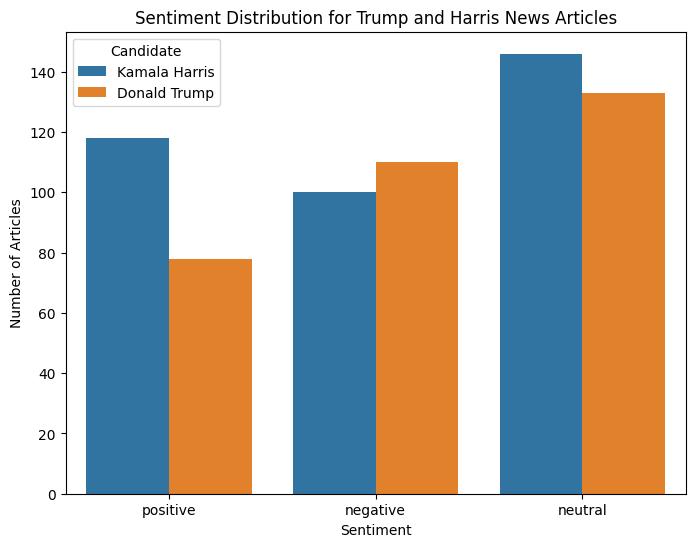

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize Sentiment Intensity Analyzer
sid = SentimentIntensityAnalyzer()

def calculate_sentiment_distribution(articles):
    """
    Calculate the number of positive, negative, and neutral articles based on compound sentiment scores.
    """
    sentiments = {'positive': 0, 'negative': 0, 'neutral': 0}

    for article in articles:
        compound_score = sid.polarity_scores(article.get('article'))['compound']
        
        if compound_score > 0.5:
            sentiments['positive'] += 1
        elif compound_score < -0.5:
            sentiments['negative'] += 1
        else:
            sentiments['neutral'] += 1
    
    return sentiments

harris_sentiment_distribution = calculate_sentiment_distribution(harris_data)
trump_sentiment_distribution = calculate_sentiment_distribution(trump_data)

sentiment_labels = ['positive', 'negative', 'neutral']
harris_counts = [harris_sentiment_distribution[sentiment] for sentiment in sentiment_labels]
trump_counts = [trump_sentiment_distribution[sentiment] for sentiment in sentiment_labels]

df_sentiment = pd.DataFrame({
    'Sentiment': sentiment_labels * 2,
    'Count': harris_counts + trump_counts,
    'Candidate': ['Kamala Harris'] * 3 + ['Donald Trump'] * 3
})

plt.figure(figsize=(8, 6))
sns.barplot(x='Sentiment', y='Count', hue='Candidate', data=df_sentiment)
plt.title('Sentiment Distribution for Trump and Harris News Articles')
plt.ylabel('Number of Articles')
plt.show()



                                             article     candidate  \
0  hit promise mass deportation candidate break b...  Donald Trump   
1  today lucky day cnn conservative put spot mark...  Donald Trump   
2  vance done time medium historically reclusive ...  Donald Trump   
3  say israel eradicated loses told largely jewis...  Donald Trump   
4  teamster skip presidential endorsement member ...  Donald Trump   

   trump_score           publishedAt  combined_score  kamala_score  
0      -0.1027  2024-09-18T11:08:51Z         -0.1027           NaN  
1      -0.0258  2024-09-20T10:54:43Z         -0.0258           NaN  
2       0.0000  2024-09-19T13:45:03Z          0.0000           NaN  
3      -0.3182  2024-09-20T01:34:13Z         -0.3182           NaN  
4       0.3182  2024-09-18T21:41:39Z          0.3182           NaN  
       trump_score  combined_score  kamala_score
count   321.000000      685.000000    364.000000
mean     -0.095115       -0.023774     -0.039140
std       0.404418

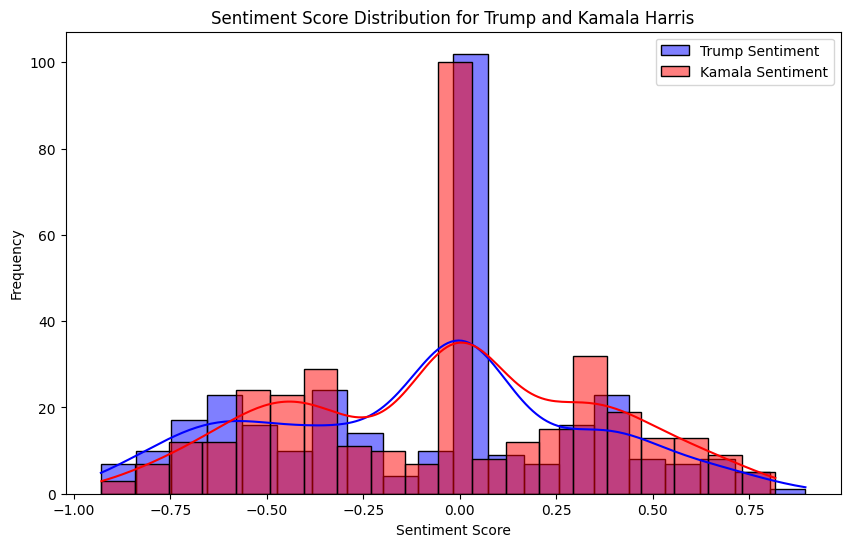

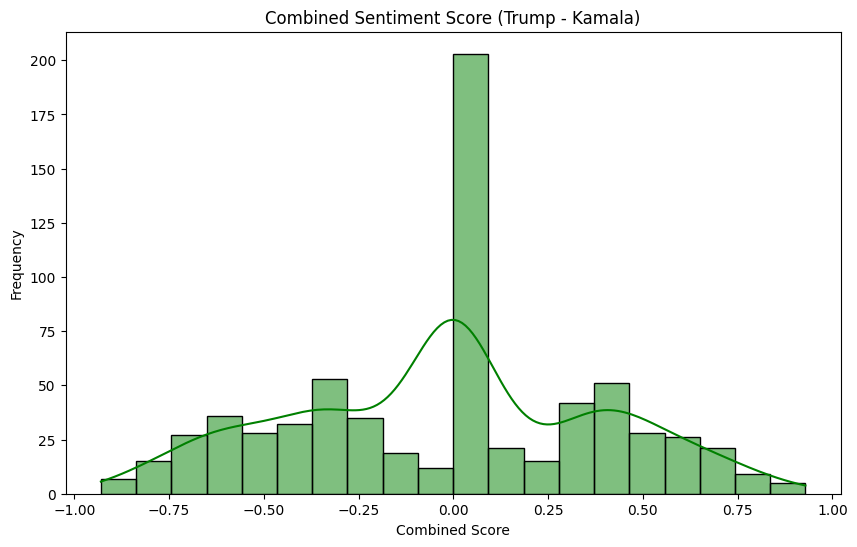

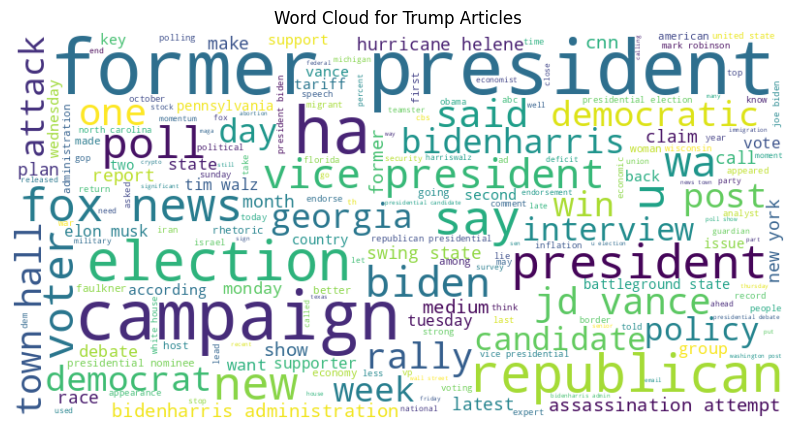

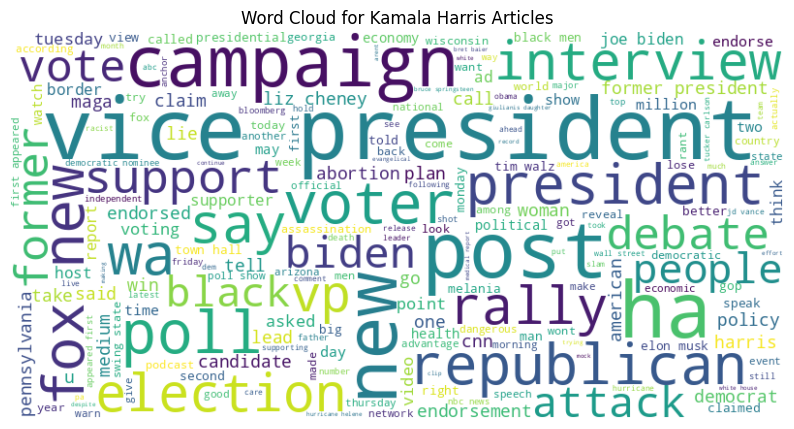

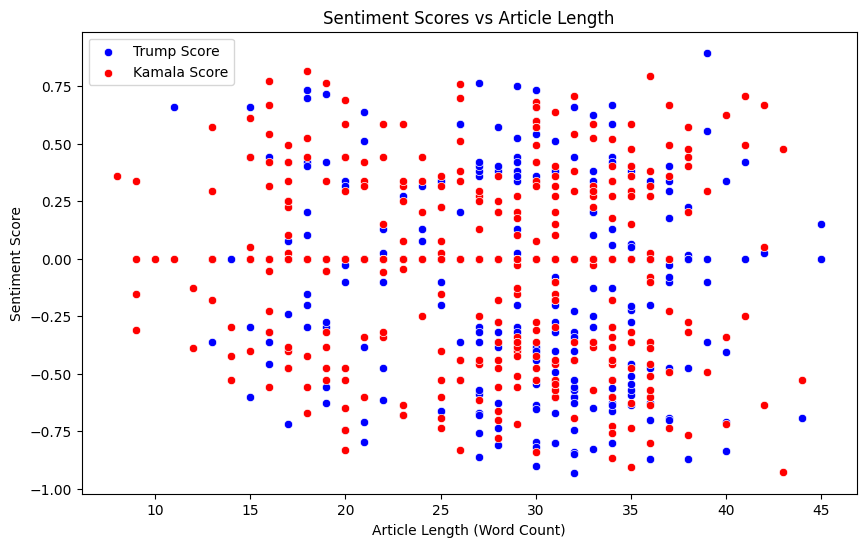

/tmp/ipykernel_11801/3109109321.py:83: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_trump_daily = df_trump.groupby(df_trump['date'].dt.to_period("D"))['combined_score'].mean()


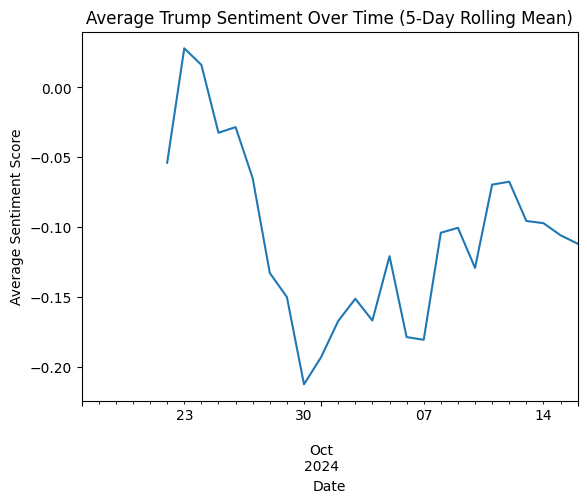

/tmp/ipykernel_11801/3109109321.py:90: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_harris_daily = df_harris.groupby(df_harris['date'].dt.to_period("D"))['combined_score'].mean()


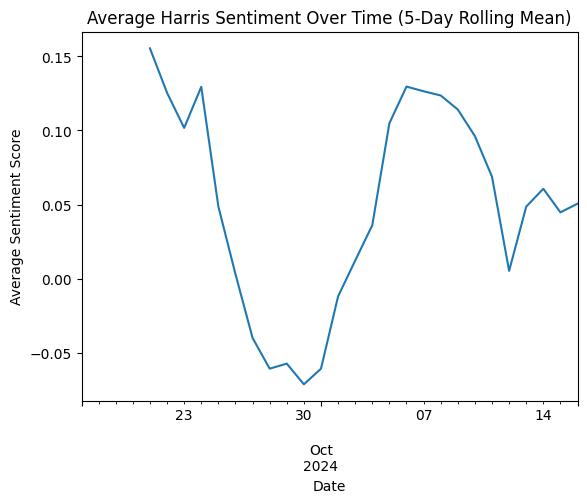

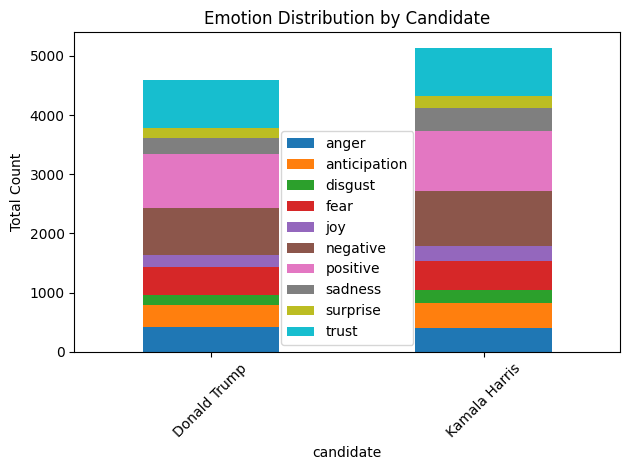

Most positive article for Trump: outstanding enthusiastic praise mark robinson recirculates candidate black nazi brag revealed mark robinson therepublican nominee governor north carolina wa exposed thursday afternoon extensive comment history pornography forum called nude africa called black nazi attacked martin luther king jr repeatedly
Most negative article for Trump: slam pelosis sick evil doubling enemy within rhetoric former president doubled attack democrat enemy within namechecked speaker emerita nancy pelosi well husband paul pelosi sick evil escalated rhetoric fox news town hall
Most positive article for Kamala: ha reached ceiling ability make gain week presidential election poll side dead heat result may hinge come vote
Most negative article for Kamala: rage fake news reporter mcdonalds story rally rant vow next week hell try french fry job raged fake news reporter failing report baseless assertion vp lied working mcdonalds post rage fake news reporter mcdonalds story rally r

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

df_trump = pd.DataFrame(trump_data)
df_harris = pd.DataFrame(harris_data)

df_trump = df_trump.rename(columns={'score': 'trump_score'})
df_harris = df_harris.rename(columns={'score': 'kamala_score'})

# Add a 'combined_score' column to reflect sentiment difference (Trump - Kamala)
df_trump['combined_score'] = df_trump['trump_score']
df_harris['combined_score'] = -df_harris['kamala_score']


df = pd.concat([df_trump, df_harris], ignore_index=True)

print(df.head())


print(df.describe())

print(f"Total number of articles: {len(df)}")

# Count articles favoring Trump (combined_score > 0) vs Kamala (combined_score < 0)
trump_favored = (df['combined_score'] > 0).sum()
kamala_favored = (df['combined_score'] < 0).sum()
print(f"Articles favoring Trump: {trump_favored}")
print(f"Articles favoring Kamala: {kamala_favored}")

# Distribution of Trump and Kamala sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(df_trump['trump_score'], color='blue', label='Trump Sentiment', kde=True, bins=20)
sns.histplot(df_harris['kamala_score'], color='red', label='Kamala Sentiment', kde=True, bins=20)
plt.title('Sentiment Score Distribution for Trump and Kamala Harris')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Combined sentiment score (Trump - Kamala)
plt.figure(figsize=(10, 6))
sns.histplot(df['combined_score'], color='green', kde=True, bins=20)
plt.title('Combined Sentiment Score (Trump - Kamala)')
plt.xlabel('Combined Score')
plt.ylabel('Frequency')
plt.show()

# Function to create word cloud
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

trump_articles_text = " ".join(df_trump['article'])
kamala_articles_text = " ".join(df_harris['article'])

plot_wordcloud(trump_articles_text, "Word Cloud for Trump Articles")
plot_wordcloud(kamala_articles_text, "Word Cloud for Kamala Harris Articles")

df_trump['article_length'] = df_trump['article'].apply(lambda x: len(x.split()))
df_harris['article_length'] = df_harris['article'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.scatterplot(x='article_length', y='trump_score', data=df_trump, label='Trump Score', color='blue')
sns.scatterplot(x='article_length', y='kamala_score', data=df_harris, label='Kamala Score', color='red')
plt.title('Sentiment Scores vs Article Length')
plt.xlabel('Article Length (Word Count)')
plt.ylabel('Sentiment Score')
plt.legend()
plt.show()

df_trump['date'] = pd.to_datetime(df_trump['publishedAt'])
df_harris['date'] = pd.to_datetime(df_harris['publishedAt'])



# Group by day and apply a rolling mean to smooth the data
df_trump_daily = df_trump.groupby(df_trump['date'].dt.to_period("D"))['combined_score'].mean()
df_trump_daily.rolling(window=5).mean().plot()
plt.title('Average Trump Sentiment Over Time (5-Day Rolling Mean)')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.show()

df_harris_daily = df_harris.groupby(df_harris['date'].dt.to_period("D"))['combined_score'].mean()
df_harris_daily.rolling(window=5).mean().plot()
plt.title('Average Harris Sentiment Over Time (5-Day Rolling Mean)')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.show()


emotion_counts = df_emotions.groupby('candidate')[['anger', 'anticipation', 'disgust', 'fear', 
                                                    'joy', 'negative', 'positive', 'sadness', 
                                                    'surprise', 'trust']].sum()

emotion_counts.plot(kind='bar', stacked=True)
plt.title('Emotion Distribution by Candidate')
plt.ylabel('Total Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Find the most positive/negative articles for Trump and Kamala
most_positive_trump = df_trump.loc[df_trump['trump_score'].idxmax()]['article']
most_negative_trump = df_trump.loc[df_trump['trump_score'].idxmin()]['article']
most_positive_kamala = df_harris.loc[df_harris['kamala_score'].idxmax()]['article']
most_negative_kamala = df_harris.loc[df_harris['kamala_score'].idxmin()]['article']

print(f"Most positive article for Trump: {most_positive_trump}")
print(f"Most negative article for Trump: {most_negative_trump}")
print(f"Most positive article for Kamala: {most_positive_kamala}")
print(f"Most negative article for Kamala: {most_negative_kamala}")
